In [110]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True)  #important for L-BFGS

import jax
import jax.numpy as np

import pylab as plt
import imageio
import os
import numpy as onp
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import scipy

# Exercise 3: SIR estimation

Consider a population with a fraction $S \in (0,1)$ of people susceptible of contracting a disease, a fraction $I \in (0,1)$ of infected people, and a fraction $R \in (0,1)$ of recovered people. 
If at day $t$ the values of these fractions are $(S_t, I_t, R_t)$, the values at day $t+1$ are 

$$S_{t+1} = \frac{\widehat{S}_{t+1}}{\widehat{S}_{t+1}+\widehat{I}_{t+1}+\widehat{R}_{t+1}}
\qquad \textrm{and} \qquad
I_{t+1} = \frac{\widehat{I}_{t+1}}{\widehat{S}_{t+1}+\widehat{I}_{t+1}+\widehat{R}_{t+1}}
\qquad \textrm{and} \qquad
R_{t+1} = \frac{\widehat{R}_{t+1}}{\widehat{S}_{t+1}+\widehat{I}_{t+1}+\widehat{R}_{t+1}}
$$

where

$$
\widehat{S}_{t+1} = S_t \, \exp[-\beta \, I_t]
\qquad \textrm{and} \qquad
\widehat{I}_{t+1} = I_t \, \exp[\beta \, S_t - \gamma]
\qquad \textrm{and} \qquad
\widehat{R}_{t+1} = R_t + \gamma \, I_t.
$$

for some unkown parameter $\beta > 0$ and $\gamma > 0$ to be estimated.
Assume that $S_0 = 0.99$ and $I_0=0.01$ and $R_0=0$. One collects data $[y_1, y_2, \ldots, y_{30}]$ during 30 consecutive days where  

$$y_t \sim \mathbf{Poisson}(\textrm{mean}=1000 \times I_t)$$

**Question 1:** Find the maximum likelihood estimates of the parameter $\beta$ and $\gamma$.  
**Question 2:** Generate artificial observations from your fitted model and check whether the artificial observations are close to the collected observations.  
**Question 3:** Can you give a confidence interval for your estimate of $\beta$ and $\gamma$? [this can be done by computing the inverse of the Hessian at the MLE, etc... If you do not know how to do this, google it.] 

**Remark:** the parameter $\beta$ and $\gamma$ are positive. It may be useful to reparametrize the model in terms of $B = \log[\beta]$ and $G = \log[\gamma]$.  
**Remark:** Note that if you use `jax`, it is normal that it takes a bit of time to compute the gradients.   
**Remark:** Note that if you use `jax.jit`, it is normal that it takes a bit of time the first time that the gradient is computed. That is because it is difficult to optimize functions with `for` loops inside them.

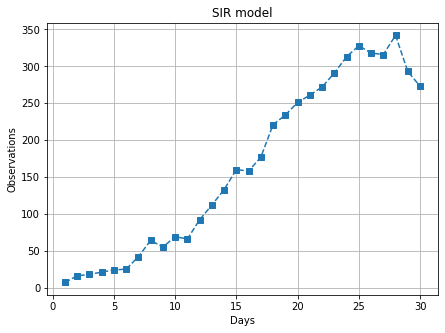

In [3]:
plt.figure(figsize=(7,5))
y_history = onp.array([7, 16, 18, 21, 24, 25, 42, 64, 55, 69, 66, 92, 112, 133, 160, 158, 177, 221, 234, 251, 261, 272, 291, 313, 328, 318, 316, 342, 293, 273])
plt.plot(np.arange(1,31), y_history, "--s")
plt.ylabel("Observations")
plt.xlabel("Days")
plt.title("SIR model")
plt.grid(True)

## Q1: Maximum Likelihood Estimates for $\beta, \gamma$

In [222]:
# define recursive function to generate population at time t based on beta and gamma
def pop(t, beta, gamma):
    if t==0:
        """return initial S I R proportion"""
        return (0.99,0.01,0) 
    else:
        S, I, R = pop(t-1, beta, gamma)
        S_new = S*np.exp(-beta*I)
        I_new = I*np.exp(beta*S-gamma)
        R_new = R + gamma*I
        return (S_new,I_new,R_new)

In [223]:
def mean_negll(beta, gamma):
    lambda_t = np.array([1000*pop(i, beta, gamma)[1] for i in range(1,31)])
    y_t = y_history
    return -np.mean(-lambda_t + y_t*np.log(lambda_t))

In [224]:
def loss(x):
    """" loss == mean negative log likelihood """
    beta = np.exp(x[0]) # reparameterise
    gamma = np.exp(x[1]) # reparameterise
    return mean_negll(beta, gamma)

grad_loss = jax.jit(jax.grad(loss))

In [225]:
x_init = onp.array([0.01,0.01])
#grad_loss(x_init)

In [226]:
def gradient_wrapper(x):
    """ compute the gradient of func at x and make sure that the output is a numpy array"""
    return onp.array(grad_loss(x))

loss_history = []  #to save the loss trajectory

def save_traj(x):
    """ a function that saves a few statistics for later analysis"""
    loss_history.append(loss(x))

traj = scipy.optimize.minimize(fun = loss, #function to minimize
                                x0 = onp.array(x_init), #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=gradient_wrapper, #function that computes the gradient
                                callback=save_traj, #a function used to save some results for later pltting
                                tol = 10**-10,
                                options={"maxiter":100})  #maximum number of iteration

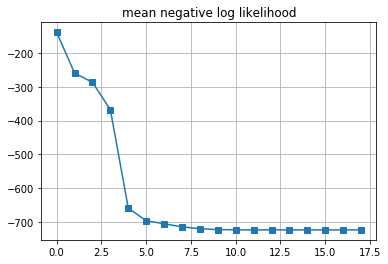

In [227]:
plt.plot(loss_history, "-s")
plt.title("mean negative log likelihood")
plt.grid(True)

In [228]:
beta_MLE = onp.exp(traj['x'][0])
gamma_MLE = onp.exp(traj['x'][1])
beta_MLE, gamma_MLE

(0.3115381520855594, 0.11134842236946554)

## Q2. Comparison between artificial and collected data

In [232]:
# compute lambda for each day
test = [pop(i, beta_MLE, gamma_MLE) for i in range(1,31)]
test_lambda = [1000*i[1] for i in test]

# simulate artifical data from Poisson(lambda)
test_I = [onp.random.poisson(i) for i in test_lambda]

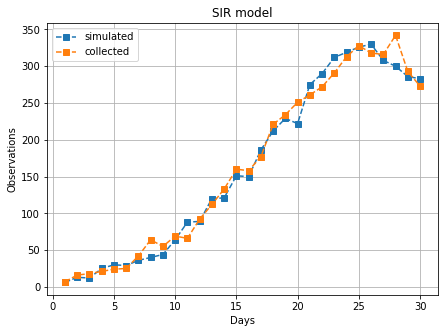

In [233]:
plt.figure(figsize=(7,5))
y_history = onp.array([7, 16, 18, 21, 24, 25, 42, 64, 55, 69, 66, 92, 112, 133, 160, 158, 177, 221, 234, 251, 261, 272, 291, 313, 328, 318, 316, 342, 293, 273])
plt.plot(np.arange(1,31), test_I, "--s", label='simulated')
plt.plot(np.arange(1,31), y_history, "--s", label='collected')
plt.ylabel("Observations")
plt.xlabel("Days")
plt.title("SIR model")
plt.legend()
plt.grid(True)

The artificial observations generated from the fitted model seem close to the collected observations.

## Q3. Confidence Intervals for estimated 𝛽 and 𝛾

In [234]:
def true_negll(z):
    beta, gamma = z[0], z[1]
    lambda_t = np.array([1000*pop(i, beta, gamma)[1] for i in range(1,31)])
    y_t = y_history
    return -np.sum(-lambda_t + y_t*np.log(lambda_t))

# compute the Hessian
hess_neg_loglik = jax.hessian(true_negll)

In [235]:
# compute the Hessian at the MLE
param_MLE = onp.array([beta_MLE, gamma_MLE])
hessian = hess_neg_loglik(param_MLE)

# compute the inverse of Hessian at MLE to approximate covariance
covariance_MLE = onp.linalg.inv(hessian)

In [236]:
# compute the marginal standard dev
std_beta = onp.sqrt(covariance_MLE[0,0])
std_gamma = onp.sqrt(covariance_MLE[1,1])

In [237]:
print("MLE estimates: \t MLE(beta)={0:.6f} \t MLE(gamma)={1:.6f}".format(std_beta, std_gamma))

MLE estimates: 	 MLE(beta)=0.004660 	 MLE(gamma)=0.002975


In [238]:
print("90% CI for beta is about [{0:2.4f},{1:2.4f}]".format(beta_MLE - 2*std_beta, beta_MLE + 2*std_beta))
print("90% CI for gamma is about [{0:2.4f},{1:2.4f}]".format(gamma_MLE - 2*std_gamma, gamma_MLE + 2*std_gamma))

90% CI for beta is about [0.3022,0.3209]
90% CI for gamma is about [0.1054,0.1173]
